In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import RandomOverSampler
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import warnings
warnings.filterwarnings("ignore")

In [7]:
# Load dataset
file_path = "data/featured_clinvar_result.csv"  # Change path if needed
df = pd.read_csv(file_path)

In [8]:
# Drop unused columns
X = df.drop(columns=["position", "label"])
y = df["label"]

In [9]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Oversample the training set
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

# Ensure int32 dtype
X_train = X_train.astype("int32")
X_test = X_test.astype("int32")

In [10]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
# Reshape for LSTM [samples, time_steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [12]:
# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# DataLoaders
dtrain = TensorDataset(X_train_tensor, y_train_tensor)
dtest = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(dtrain, batch_size=64, shuffle=True)
test_loader = DataLoader(dtest, batch_size=64, shuffle=False)

In [13]:
# Define RNN-LSTM model
def define_model(trial):
    input_size = X_train.shape[2]
    hidden_size = trial.suggest_int("hidden_size", 16, 128)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)

    class RNNModel(nn.Module):
        def __init__(self):
            super(RNNModel, self).__init__()
            self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                                num_layers=num_layers, batch_first=True, dropout=dropout)
            self.fc = nn.Linear(hidden_size, 2)

        def forward(self, x):
            out, _ = self.lstm(x)
            out = out[:, -1, :]
            out = self.fc(out)
            return out

    return RNNModel()

In [14]:
# Training function
def train(model, optimizer, criterion):
    model.train()
    epoch_loss, correct, total = 0.0, 0, 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, pred = torch.max(out, 1)
        correct += (pred == yb).sum().item()
        total += yb.size(0)
    return epoch_loss / len(train_loader), correct / total

# Validation function
def validate(model, criterion):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in test_loader:
            out = model(xb)
            loss = criterion(out, yb)
            val_loss += loss.item()
            _, pred = torch.max(out, 1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)
    return val_loss / len(test_loader), correct / total

In [15]:
# Evaluation function
def evaluate(model):
    model.eval()
    preds, true = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            out = model(xb)
            _, predicted = torch.max(out, 1)
            preds.extend(predicted.numpy())
            true.extend(yb.numpy())
    return preds, true

In [16]:
# Objective function for Optuna
def objective(trial):
    model = define_model(trial)
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(50):
        train_loss, train_acc = train(model, optimizer, criterion)
    preds, true = evaluate(model)
    return accuracy_score(true, preds)

In [17]:
# Run Optuna Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

[I 2025-06-26 18:15:05,248] A new study created in memory with name: no-name-3d262358-042f-4d26-88ad-ea8aa721ca23
[I 2025-06-26 18:15:12,559] Trial 0 finished with value: 0.9506172839506173 and parameters: {'hidden_size': 85, 'num_layers': 3, 'dropout': 0.17190922209187898, 'lr': 0.003258347613077403}. Best is trial 0 with value: 0.9506172839506173.
[I 2025-06-26 18:15:15,042] Trial 1 finished with value: 0.9547325102880658 and parameters: {'hidden_size': 29, 'num_layers': 2, 'dropout': 0.4546925254948003, 'lr': 0.012105824963427105}. Best is trial 1 with value: 0.9547325102880658.
[I 2025-06-26 18:15:19,234] Trial 2 finished with value: 0.9423868312757202 and parameters: {'hidden_size': 90, 'num_layers': 3, 'dropout': 0.24152736636691877, 'lr': 0.03765834947769552}. Best is trial 1 with value: 0.9547325102880658.
[I 2025-06-26 18:15:21,961] Trial 3 finished with value: 0.9506172839506173 and parameters: {'hidden_size': 51, 'num_layers': 2, 'dropout': 0.20361515617487821, 'lr': 0.00205

In [18]:
# Train best model
best_trial = study.best_trial
best_model = define_model(best_trial)
optimizer = optim.Adam(best_model.parameters(), lr=best_trial.params['lr'])
criterion = nn.CrossEntropyLoss()

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(70):
    train_loss, train_acc = train(best_model, optimizer, criterion)
    val_loss, val_acc = validate(best_model, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

In [19]:
# Final Evaluation
preds, true = evaluate(best_model)
results = {
    "Accuracy": accuracy_score(true, preds),
    "Precision": precision_score(true, preds),
    "Recall": recall_score(true, preds),
    "F1 Score": f1_score(true, preds)
}

results_df = pd.DataFrame([results])
print(results_df)

   Accuracy  Precision    Recall  F1 Score
0  0.950617   0.926829  0.974359      0.95


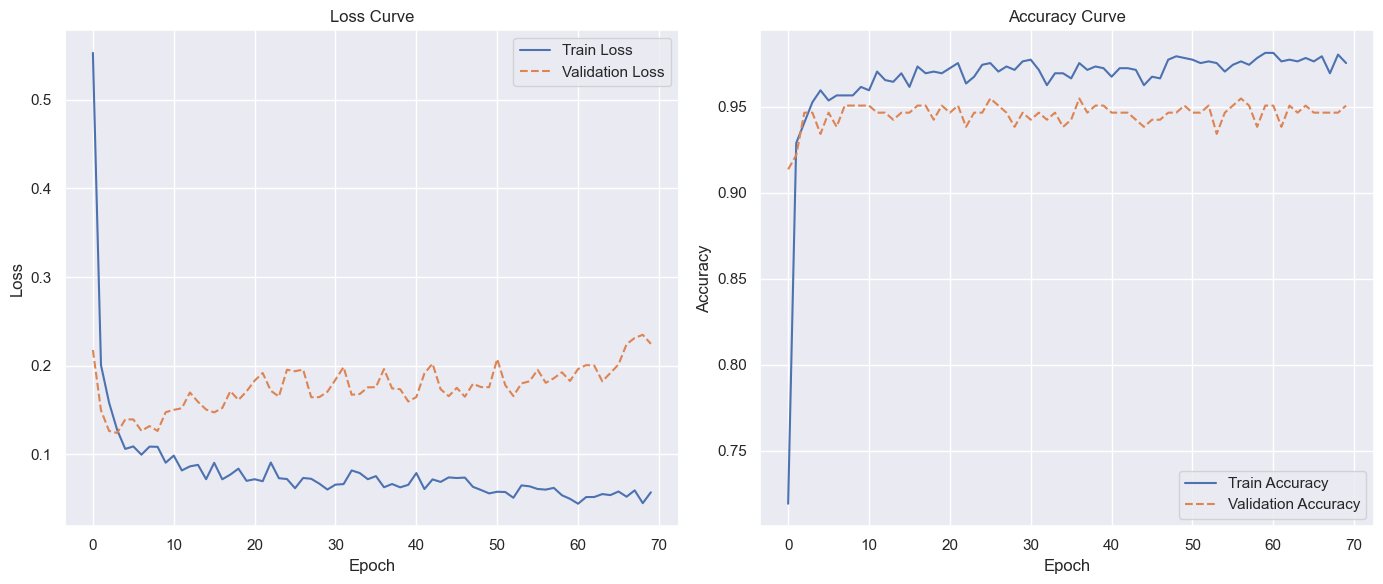

In [20]:
# Plotting
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss", linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy", linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()